<h1>Deploying Hugging Face Models<h1>



In [1]:
!pip install transformers pandas torch datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
#upload car review file
from google.colab import files
uploaded = files.upload()

Saving car_reviews.csv to car_reviews.csv


In [3]:
import pandas as pd
df = pd.read_csv('car_reviews.csv')

<h2>NLP Model Selection for Review Classification</h2>

<p><strong>Model Chosen : </strong>facebook/bart-large-mnli</p>

<p><strong>Reasons : </strong></p>
  <ul>
    <li>This model is designed for Natural Language Inference (NLI) tasks and performs well in zero-shot classification.</li>
    <li>This model can classify texts into custom classes without retraining.</li>
    <li>This model can handle larger and complex texts.</li>
  </ul>

In [4]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [5]:
class_labels = [
    "Talks about driving experience",
    "Talks about features",
    "Talks about value for money",
    "Talks about issues",
    "Other"
]

In [6]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)

def classify_reviews(reviews):
    results = classifier(reviews['Review'], candidate_labels=class_labels)
    return {
        "class": [result['labels'][0] for result in results],
        "score": [result['scores'][0] for result in results]
    }

classified_dataset = dataset.map(classify_reviews, batched=True, batch_size=128)

Map:   0%|          | 0/5959 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [7]:
print(classified_dataset)

Dataset({
    features: ['Review', 'class', 'score'],
    num_rows: 5959
})


In [8]:
print(classified_dataset['class'][:10])
print(classified_dataset['score'][:10])

['Talks about value for money', 'Talks about value for money', 'Talks about value for money', 'Talks about issues', 'Talks about value for money', 'Talks about issues', 'Talks about value for money', 'Talks about driving experience', 'Talks about driving experience', 'Talks about value for money']
[0.5374966859817505, 0.7576693892478943, 0.5380462408065796, 0.4684707522392273, 0.5198899507522583, 0.42335209250450134, 0.7301025390625, 0.381466805934906, 0.44012218713760376, 0.26754873991012573]


In [9]:
classified_df = classified_dataset.to_pandas()

assert len(df) == len(classified_df), "Row counts do not match!"

df['talks_about'] = classified_df['class']

In [10]:
df

,Review,talks_about
0,Bought 2017 Optima Hybrid in November 17. It w...,Talks about value for money
1,You get a lot for your money and great perfor...,Talks about value for money
2,This car is amazing and have no complaints. Y...,Talks about value for money
3,At 11k now in a lease for 39 months and it onl...,Talks about issues
4,"I've owned BMW, Lexus, Mercedes-Benz in the la...",Talks about value for money
...,...,...
5954,"Kia did a great job with this all new car, buy...",Talks about driving experience
5955,"When purchasing the car, I read that the newl...",Talks about value for money
5956,The new designed Kia Rio is awesome. Much room...,Talks about driving experience
5957,Everyone seems so hyped on having the latest &...,Talks about value for money


<h2>NLP Model Selection for Sentiment Analysis</h2>

<p><strong>Model Chosen : </strong>cardiffnlp/twitter-roberta-base-sentiment</p>

<p><strong>Reasons : </strong></p>
  <ul>
    <li>This model is specifically fine-tuned for sentiment detection tasks</li>
    <li>Though it is trained on tweets, it can generalize well across various textual data</li>
    <li>It has been evaluated on multiple benchmark datasets and shows strong performance for sentiment detection</li>
  </ul>

In [11]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

Using device: cuda


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [12]:
from torch.nn.functional import softmax

batch_size = 128

def predict_sentiment(batch_texts):
    inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = softmax(outputs.logits, dim=1)
        sentiment_labels = probabilities.argmax(dim=1).cpu().numpy()
    return sentiment_labels

sentiment_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}

sentiments = []
for i in range(0, len(df), batch_size):
    batch_reviews = df["Review"].iloc[i:i + batch_size].tolist()
    sentiment_batch = predict_sentiment(batch_reviews)
    sentiments.extend([sentiment_mapping[label] for label in sentiment_batch])

df["sentiment"] = sentiments

In [13]:
output_file = 'classified_reviews.csv'
df.to_csv(output_file, index=False)

In [14]:
files.download(output_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
import matplotlib.pyplot as plt

<h2>Visualizing the spread of the review category using Bar Graph</h2>

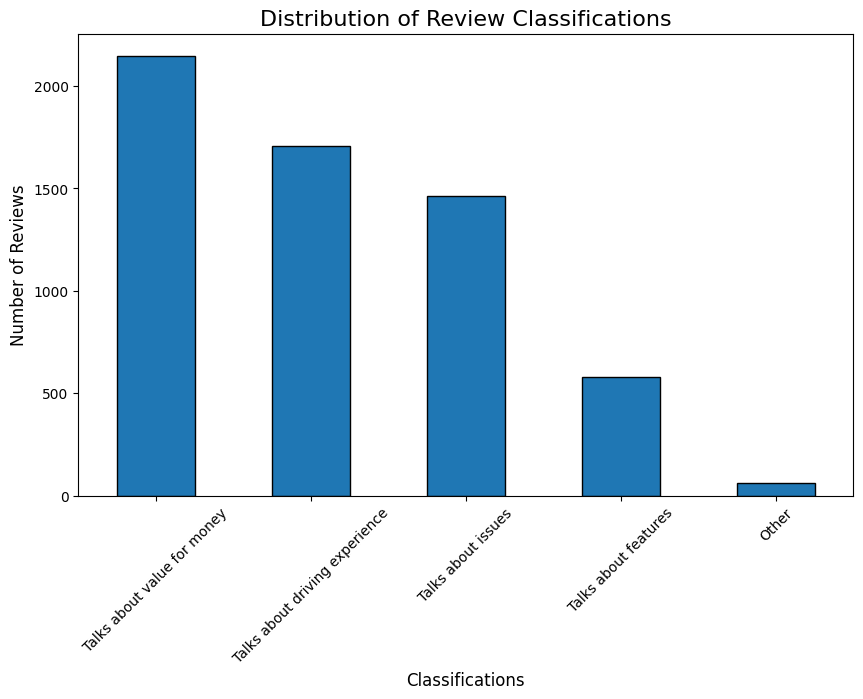

In [16]:

plt.figure(figsize=(10, 6))
df['talks_about'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Distribution of Review Classifications', fontsize=16)
plt.xlabel('Classifications', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45)
plt.show()

<h2>Visualizing the sentiment spread using Pie Chart</h2>

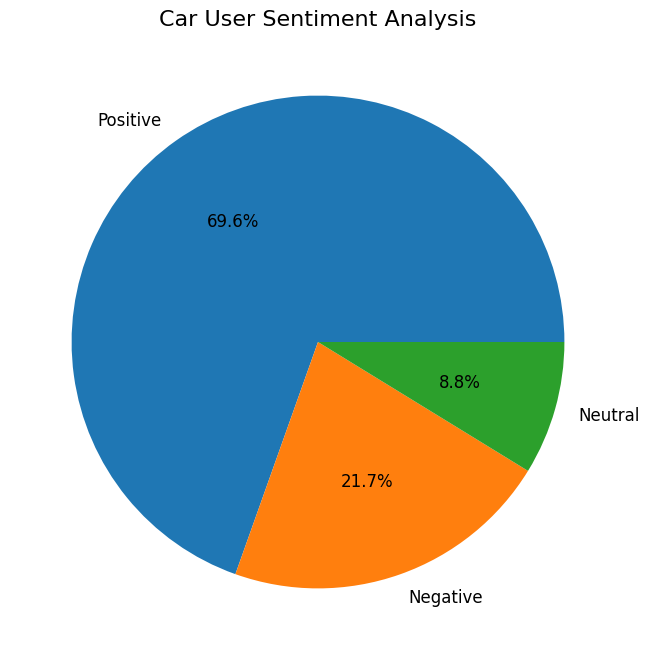

In [17]:
plt.figure(figsize=(8, 8))
df['sentiment'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    textprops={'fontsize': 12}
)

plt.title('Car User Sentiment Analysis', fontsize=16)
plt.ylabel('')
plt.show()